In [1]:
#! Python3
# by Jacob Kovach
# Confidential and Proprietary

import numpy as np, pandas as pd, urllib.request, spacy, pickle, re
from string import punctuation
from datetime import datetime, timedelta
from collections import Counter
from nltk import tokenize
from nltk.corpus import stopwords
from pandas_datareader import DataReader
from tqdm import tqdm

# Sets number of files used in training the model
file_no = 500

# Read call links from the index file
call_links = []
with open ('/Users/jkovach/Downloads/earnings-call-transcripts/_index.txt', 'r') as index:
    urls = index.readlines()
    for line in urls:
        url = line
        if len(call_links) >= file_no:
            break
        else:
            call_links.append(url)
        if len(call_links) % 500 == 0:
            print("Files Read: {}".format(len(call_links)))

# Create initial dataset
call_df = pd.DataFrame()
call_df['date_string'] = np.asarray([link[47:57] for link in call_links])
call_df['datetime'] = np.asarray(pd.to_datetime(call_df['date_string'], errors='coerce', format='%Y/%m/%d'))
call_df['filename'] = np.asarray([link[58:-6] for link in call_links])
call_df = call_df.drop('date_string', 1)
call_df.head()

Files Read: 500


,datetime,filename
0,2017-10-11,barracuda-networks-q2-2018-earnings-conference...
1,2017-10-12,delta-air-lines-q3-2017-earnings-conference-ca...
2,2017-10-12,jp-morgan-chase-co-q3-2017-earnings-conference...
3,2017-10-13,citigroup-q3-2017-earnings-conference-call-tra...
4,2017-10-16,bank-of-america-corporation-q3-2017-earnings-c...


In [2]:
# Define nlp dictionary and folder location for transcripts
nlp = spacy.load('en')
root = '/Users/jkovach/Downloads/earnings-call-transcripts/'

# Regex objects
ticker_re = re.compile(r'\:[A-Z]+\)')
dur_re = re.compile(r'(Duration: )(\d+)')
chars = (punctuation + '0123456789').replace('-', '')

# Define functions for getting and cleaning text, ticker, duration, etc. 
def text_cleaner(f):
    filepath = root + f + '.txt'
    try:
        with open (filepath, 'r') as tf:

            # Gets the raw text and apply cleaning procedures
            raw_text = re.sub(r'([a-z0-9][\.:\?]?)([A-Z])', r'\1\n\2', tf.read())
            raw_text = re.sub(r'www\.\S+\.com', '', raw_text)
            raw_text = re.sub(r'--', '', raw_text)
            raw_text = re.sub(r'\[.*\]', '', raw_text)
    except:
        raw_text = ""

    # Additional text cleaning
    content = ' '.join([sent for sent in tokenize.sent_tokenize(raw_text) 
                        if len(sent.split())>12 and ":\n" not in sent][:-1])
    content = ' '.join(word for word in content.split() if not word.istitle())
    content = re.sub(r'[A-Z]{2,}', '', content)
    content = content.replace('-', ' ')
    content = content.replace("'", '')
    content = ' '.join([word for word in tokenize.word_tokenize(content) if word.isalpha()])
    content = ' '.join([word.lemma_.lower() for word in nlp(content) 
                        if not word.is_stop and len(word)>1])
        
    return raw_text, content

def get_duration(raw):
    try:
        duration = dur_re.search(raw).group(2)
    except:
        duration = np.nan
    return duration

def get_ticker(raw):
    ts=""
    for sent in tokenize.sent_tokenize(raw)[0:2]:
        try:
            ts += ticker_re.search(sent).group()
        except:
            ts=ts
    return ts[1:-1]

# Utility function to get 7-day movement of stock, beginning the day before the call
def price_delta(ticker, date):
    s = date - timedelta(days=3)
    e = date + timedelta(days=10)
    stock_df = DataReader(ticker, "yahoo", s, e).reset_index()
    cur_date_index = stock_df[stock_df['Date'] == date].index[0]
    min1 = stock_df.loc[cur_date_index-1, 'Close']
    plus7 = stock_df.loc[cur_date_index+5, 'Close']
    delta7 = ((plus7 - min1)/min1)*100
    return delta7

# Bin price_delta into categories as outcome of interest
def change_type(change_ratio):
    if change_ratio >= 4:
        return 2
    elif change_ratio <= -4:
        return 0
    else:
        return 1

# Apply functions to dataset 
tqdm.pandas(position=0, leave=True)
call_df['raw'], call_df['content'] = zip(*call_df['filename'].progress_apply(text_cleaner))
call_df['duration'] = call_df['raw'].apply(get_duration)
call_df['ticker'] = call_df['raw'].apply(get_ticker)

for i in range(call_df.shape[0]):
    try:
        call_df.loc[i, 'price_delta'] = price_delta(call_df.loc[i, 'ticker'], call_df.loc[i, 'datetime'])
        if i % 100 == 0:
            print("Processing Row: ", i)
        
    except:
        call_df.loc[i, 'price_delta'] = np.nan

call_df['Movement'] = call_df['price_delta'].apply(change_type)
call_df = call_df.dropna().sample(frac=1).reset_index(drop=True)
call_df.head()

/Users/jkovach/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 500/500 [06:44<00:00,  1.24it/s]


Processing Row:  100
Processing Row:  200
Processing Row:  300
Processing Row:  400


,datetime,filename,raw,content,duration,ticker,price_delta,Movement
0,2017-11-09,humana-hum-q3-2017-earnings-conference-call-tr...,\n\nImage source: The Motley Fool.\n\nHumana (...,time like welcome earning like ask question ti...,64,HUM,-3.109082,1
1,2018-02-26,exelixis-inc-exel-q4-2017-earnings-conference-...,\n\nImage source: The Motley Fool.\n\nExelixis...,like turn host today thank join financial resu...,59,EXEL,-15.859032,0
2,2018-01-05,constellation-brands-inc-stz-q3-2018-earnings-...,\n\nImage source: The Motley Fool.\n\nConstell...,turn morning reminder reconciliation directly ...,74,STZ,-3.662691,1
3,2018-02-26,appian-appn-q4-2017-earnings-conference-call-t...,\n\nImage source: The Motley Fool.\n\nAppian (...,require operator assistance conference press t...,56,APPN,0.208766,1
4,2018-03-01,getty-realty-gty-q4-2017-earnings-conference-call,\n\nImage source: The Motley Fool.\n\nGetty Re...,start executive vice president general counsel...,28,GTY,5.381358,2


In [3]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create corpus of words from cleaned docs, one corpus for each class of stock movement
corpus_down = ' '.join(list(call_df[call_df['Movement']==0]['content'])).split()
corpus_n = ' '.join(list(call_df[call_df['Movement']==1]['content'])).split()
corpus_up = ' '.join(list(call_df[call_df['Movement']==2]['content'])).split()

# Visualize word clouds for each group
down_wc = WordCloud(background_color='orange').generate(' '.join(corpus_down))
n_wc = WordCloud(background_color='orange').generate(' '.join(corpus_n))
up_wc = WordCloud(background_color='orange').generate(' '.join(corpus_up))

plt.figure(figsize=(10,10))

plt.subplot(3,1,1)
plt.imshow(down_wc, interpolation='bilinear')
plt.title('Common Words: Stock Decrease')
plt.axis('off')

plt.subplot(3,1,2)
plt.imshow(n_wc, interpolation='bilinear')
plt.title('Common Words: Stock Neutral')
plt.axis('off')

plt.subplot(3,1,3)
plt.imshow(up_wc, interpolation='bilinear')
plt.title('Common Words: Stock Increase')
plt.axis('off')

plt.show()

<Figure size 1000x1000 with 3 Axes>

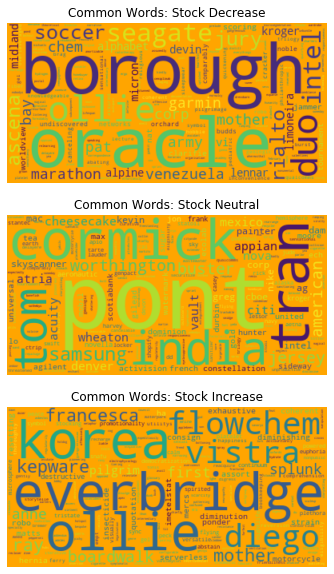

In [4]:
# Get set of all words (remove duplicate words)
corpus_all = set(corpus_down + corpus_n + corpus_up)

# Create a list of words common between all docs
common_words = []
i = 0
for word in corpus_all:
    if word in corpus_down and word in corpus_n and word in corpus_up:
        common_words.append(word)

# Utility function to create unique words for each stock movement class
def remove_common_words(corpus):
    unique_words = []
    for word in corpus:
        if word not in common_words:
            unique_words.append(word)
    
    return set(unique_words)

# Create wordclouds for unique words in each class of movement
down_unique_wc = WordCloud(background_color='orange').generate(' '.join(remove_common_words(corpus_down)))
n_unique_wc = WordCloud(background_color='orange').generate(' '.join(remove_common_words(corpus_n)))
up_unique_wc = WordCloud(background_color='orange').generate(' '.join(remove_common_words(corpus_up)))

# Visualize terms without common words
plt.figure(figsize=(10,10))

plt.subplot(3,1,1)
plt.imshow(down_unique_wc, interpolation='bilinear')
plt.title('Common Words: Stock Decrease')
plt.axis('off')

plt.subplot(3,1,2)
plt.imshow(n_unique_wc, interpolation='bilinear')
plt.title('Common Words: Stock Neutral')
plt.axis('off')

plt.subplot(3,1,3)
plt.imshow(up_unique_wc, interpolation='bilinear')
plt.title('Common Words: Stock Increase')
plt.axis('off')

plt.show()

In [5]:
# Save df to file
def save_files(var, f):
    with open (f, 'wb') as file:
        pickle.dump(var, file)

save_files(call_df, '/Users/jkovach/Downloads/earnings-call-transcripts/_call_df_' + str(file_no))
save_files(common_words, '/Users/jkovach/Downloads/earnings-call-transcripts/_common_word_list_' + str(file_no))
call_df.head()

,datetime,filename,raw,content,duration,ticker,price_delta,Movement
0,2017-11-09,humana-hum-q3-2017-earnings-conference-call-tr...,\n\nImage source: The Motley Fool.\n\nHumana (...,time like welcome earning like ask question ti...,64,HUM,-3.109082,1
1,2018-02-26,exelixis-inc-exel-q4-2017-earnings-conference-...,\n\nImage source: The Motley Fool.\n\nExelixis...,like turn host today thank join financial resu...,59,EXEL,-15.859032,0
2,2018-01-05,constellation-brands-inc-stz-q3-2018-earnings-...,\n\nImage source: The Motley Fool.\n\nConstell...,turn morning reminder reconciliation directly ...,74,STZ,-3.662691,1
3,2018-02-26,appian-appn-q4-2017-earnings-conference-call-t...,\n\nImage source: The Motley Fool.\n\nAppian (...,require operator assistance conference press t...,56,APPN,0.208766,1
4,2018-03-01,getty-realty-gty-q4-2017-earnings-conference-call,\n\nImage source: The Motley Fool.\n\nGetty Re...,start executive vice president general counsel...,28,GTY,5.381358,2
